### SARIMA with example

In [21]:
import pandas as pd
import numpy as np
from pandas import Series
from matplotlib import pyplot
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random
import itertools

import warnings
warnings.filterwarnings("ignore")


In [17]:
# loading the original dataset.
hdr = pd.read_csv('D:/internships/summer_Triassic/dataset/original/csvfiles/SalesHDR.csv', header=0, 
                  usecols = [ 'NUMCUST' ,'DATESEATED'], 
                parse_dates= ['DATESEATED'] )

In [18]:
# Renaming the column DATESEATED to DATE.
hdr_new = hdr.rename(columns = {'DATESEATED':'DATE'})

In [19]:
# setting DATE column as index. 
hdr_new.set_index('DATE',inplace=True)

# snipping for continuous data only.
hdr_new = hdr_new.loc['2016-03-06':]

# sampling based on daily values.
hdr_new_sampled = hdr_new.resample('D').sum()

In [20]:
# finding the shape of the resulted dataframe.
hdr_new_sampled.shape

(610, 1)

In [7]:
hdr_new_sampled.head(4)

,NUMCUST
DATE,
2016-03-06,434
2016-03-07,299
2016-03-08,261
2016-03-09,219


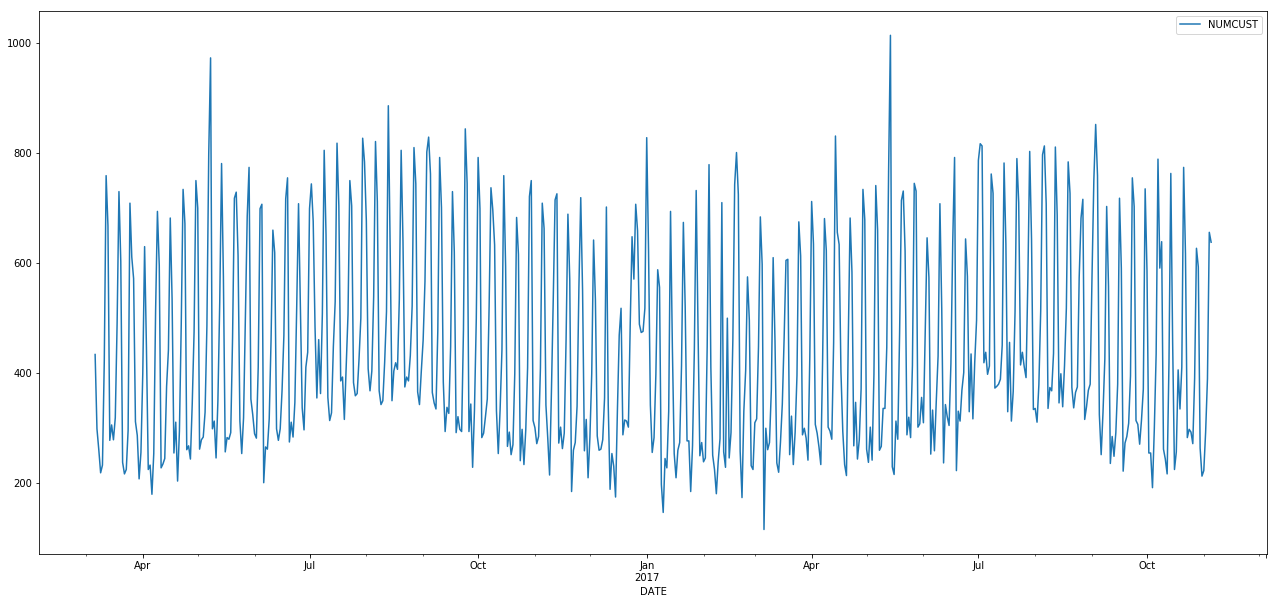

In [8]:
# plotting the data.
hdr_new_sampled.plot()

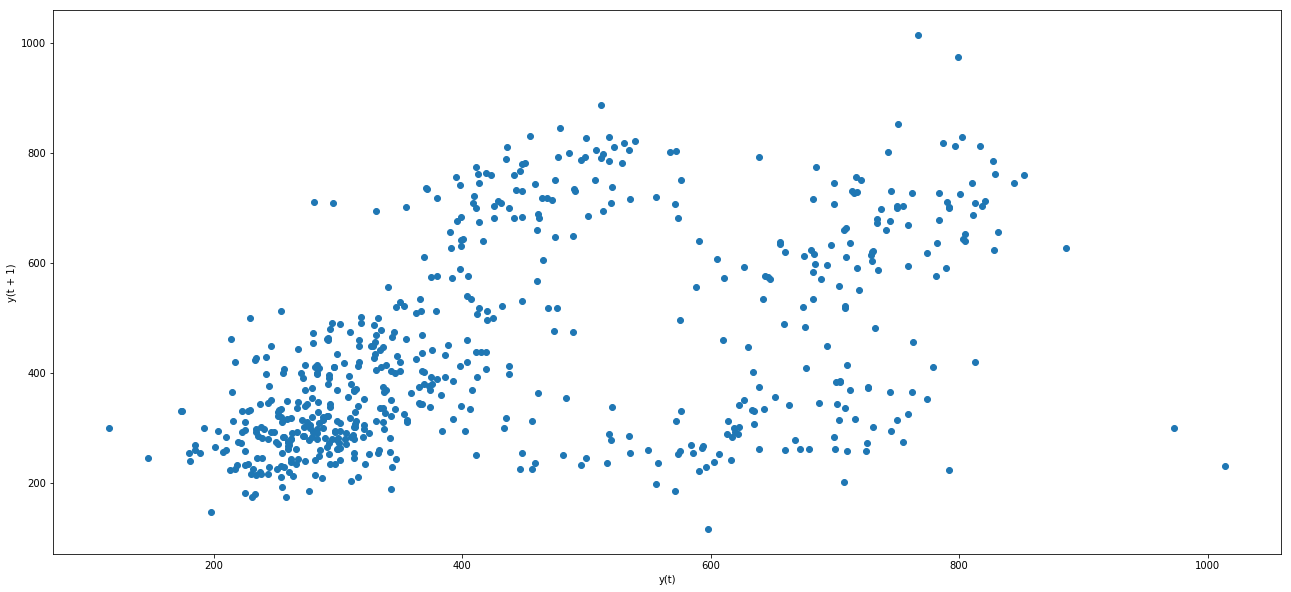

In [10]:
# lag plot of sampled data. 
lag_plot(hdr_new_sampled)

In [25]:
## The lag plot shows no good correlation between lag variables. 

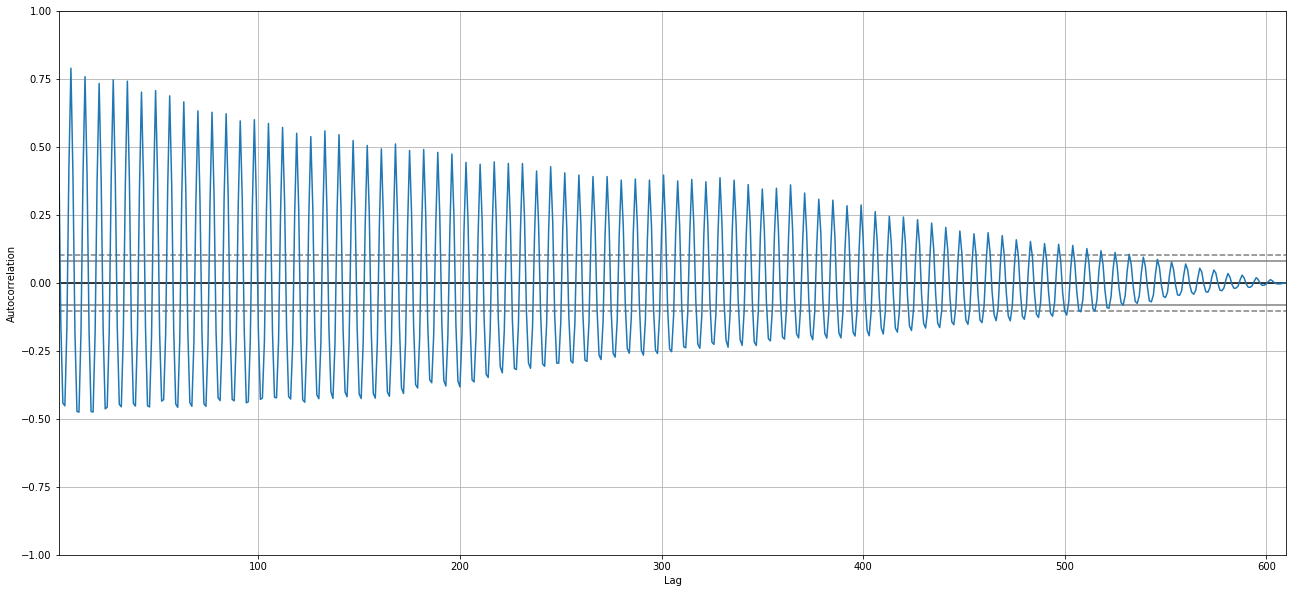

In [11]:
# autocorrelation plot of the data.
autocorrelation_plot(hdr_new_sampled)

In [13]:
# for finding the correlation.
v = DataFrame(hdr_new_sampled.values)
y = concat([v.shift(1), v], axis=1)
y.columns = ['t-1', 't+1']
result = y.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.477875
t+1  0.477875  1.000000


In [14]:
x = hdr_new_sampled
train, test = x[:520], x[520:]

In [25]:
def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    
    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]
                
                print('ARIMA{}x{}12 - AIC:{} - BIC:{}'.format(param, 
                                                          param_seasonal, 
                                                          results.aic, 
                                                          results.bic))

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    
    return best_model

In [26]:
best = find_best_sarima(train, 'aic')

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7884.968178609395 - BIC:7889.220082492561
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7367.688018472608 - BIC:7376.145040479791
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:7135.59946859333 - BIC:7148.213141881036
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:7180.405449239605 - BIC:7184.633960243196
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6634.170897214406 - BIC:6642.580012739543
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:6433.8975756705595 - BIC:6446.437625631517
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:7513.602536261147 - BIC:7517.807094023716
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:6884.293936223163 - BIC:6892.653969530468
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:6394.358340684914 - BIC:6406.822914966963
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:7152.460930674237 - BIC:7160.921893569393
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6803.8643557749965 - BIC:6816.54988878577
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:6605.240462703814 - BIC:6622.058693754088
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6951.5027437939

In [27]:

print('The best model is :')
print('  ', best)

The best model is :
   {'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x000001AF5FE2C278>, 'aic': 6026.459070250089, 'bic': 6064.24537869852, 'order': (2, 1, 2), 'seasonal_order': (2, 0, 2, 12)}


In [28]:
# fitting the model
model = SARIMAX(x, order = (2,1,2),seasonal_order =(2,0,2,12),enforce_stationarity=False,enforce_invertibility=False)
model_fit = model.fit(disp=False)

# prediction based on the model
pred = model_fit.predict(len(train), len(train)+len(test)-1, dynamic = False)
print(pred.head())


DATE
2017-08-08    381.897568
2017-08-09    315.506595
2017-08-10    492.887825
2017-08-11    588.450538
2017-08-12    704.715809
Freq: D, dtype: float64


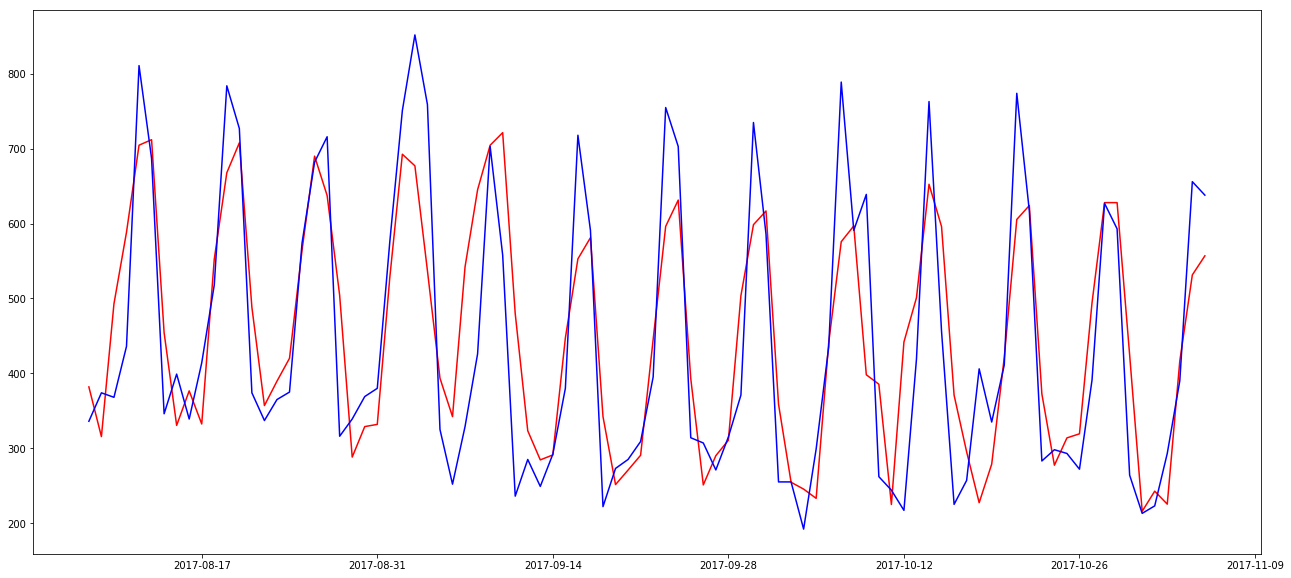

In [29]:
# plotting prediction and test 
pyplot.plot(pred, color='red')
pyplot.plot(test, color ='blue')

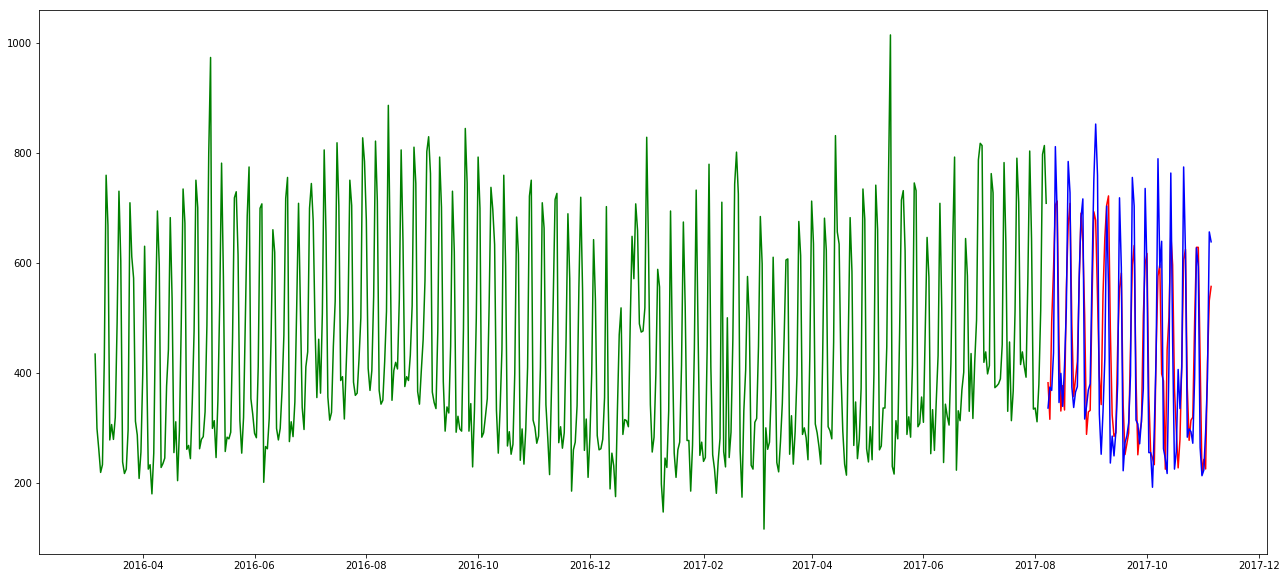

In [30]:
# visualization of train, test and prediction.
pyplot.plot(pred, color='red')
pyplot.plot(test, color ='blue')
pyplot.plot(train, color ='green')